In [335]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from scipy import stats

In [336]:
from tensorflow.keras import utils
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [337]:
# Using methods from other notebook
%run preprocessing_functions.ipynb

In [338]:
# Loading fer2013 dataset, it's already split in train and test data
train_data, train_labels = load_data('datasets/FER2013/train')
test_data, test_labels = load_data('datasets/FER2013/test')

In [339]:
# As we see, train dataset consists of 28709 images of 48 x 48 px
train_data.shape

(28709, 48, 48)

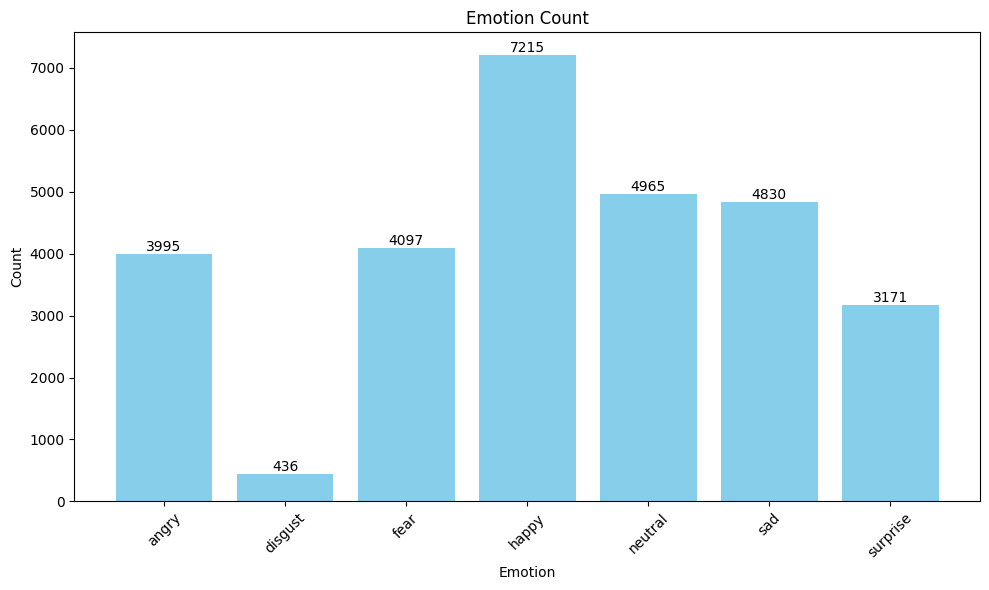

In [340]:
plot_count(train_data, train_labels)

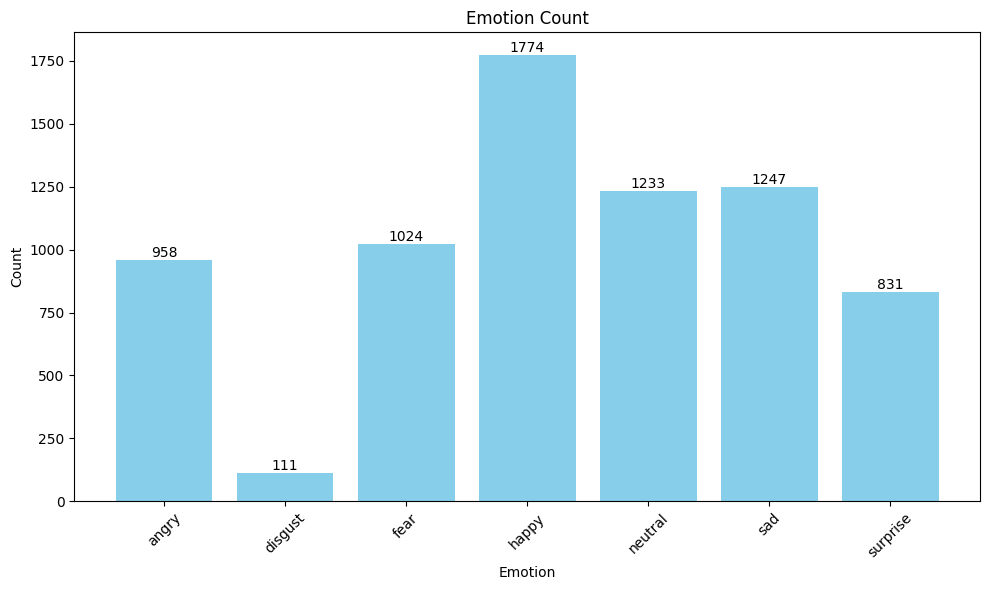

In [341]:
plot_count(test_data, test_labels)

In [342]:
# Here, we'll use different approach to unbalanced data. Because disgust is much smaller class than the others, 
# we'll make more models, and use voting when we testing

In [343]:
train_data, train_labels = add_mirrored_images_upto(train_data, train_labels, upto=436*11, include=["angry", "fear", "surprise"])

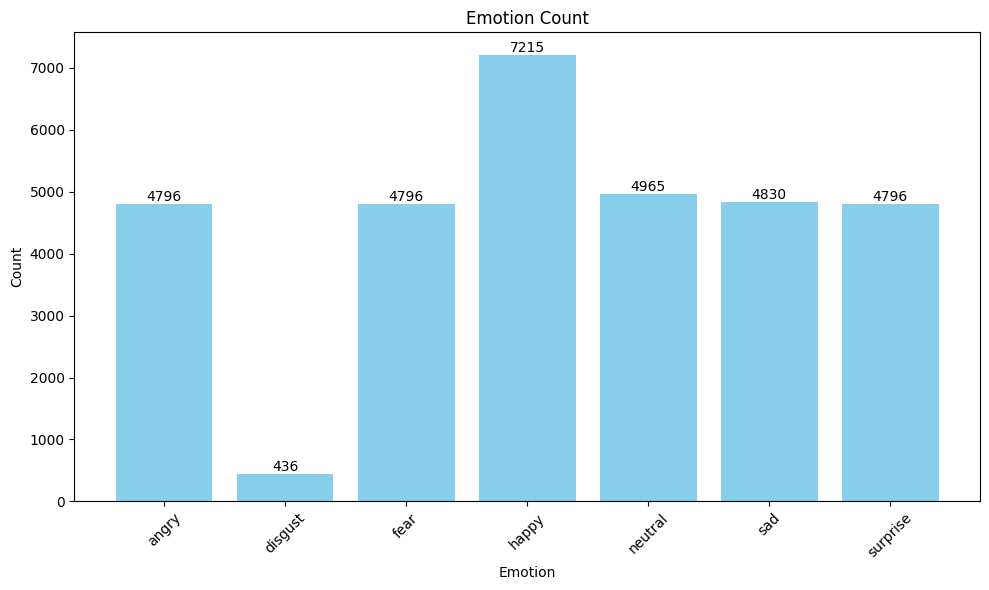

In [344]:
plot_count(train_data, train_labels)

In [345]:
seed = 12
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "happy", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "neutral", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "sad", 436*11, seed)

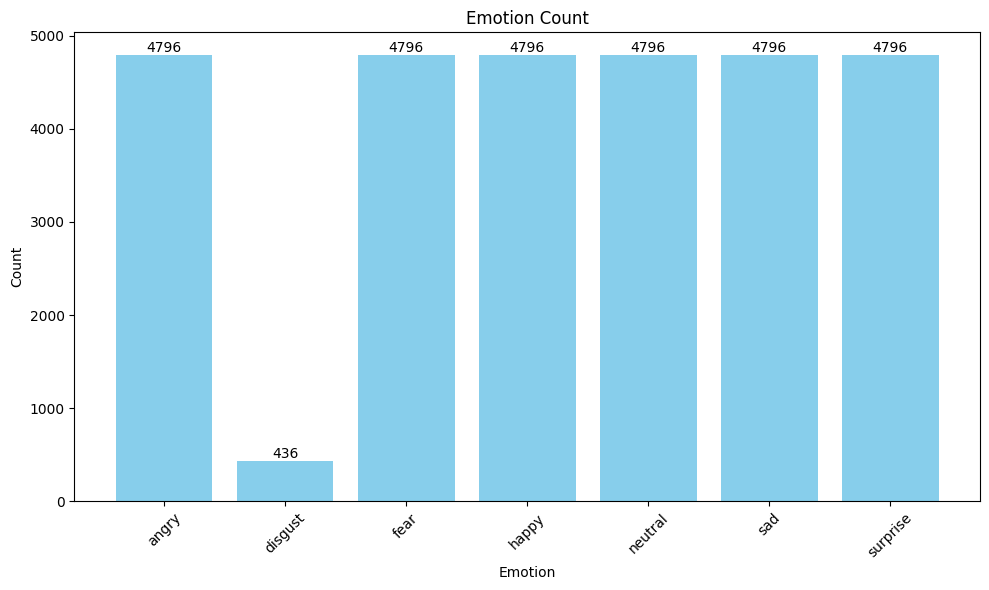

In [346]:
plot_count(train_data, train_labels)

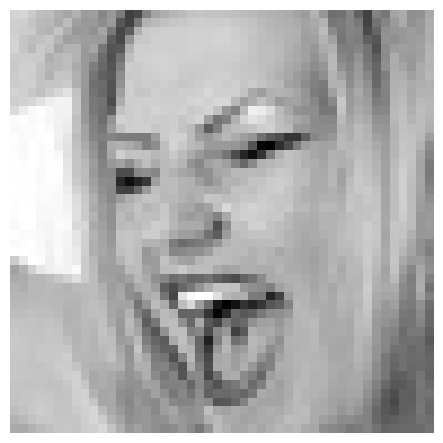

angry


In [347]:
plot_image(train_data[0], train_labels[0])

In [348]:
print(train_data[0].shape)
print(train_labels[0])

ROWS=48
COLS=48
NUM_OF_CHANNELS=1
NUM_OF_CLASSES=7
K.image_data_format()

(48, 48)
angry


'channels_last'

In [349]:
#train_data.shape
train_data=np.array(train_data)
test_data=np.array(test_data)
train_data = train_data.reshape(train_data.shape[0], ROWS, COLS, 1)
test_data = test_data.reshape(test_data.shape[0], ROWS, COLS, 1)
input_shape = (ROWS, COLS, 1)

In [350]:
print(train_data.shape)
print(test_data.shape)

(29212, 48, 48, 1)
(7178, 48, 48, 1)


In [351]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [352]:
# Maybe this is too large and complex model for our dataset!

alexnet_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu', input_shape=(ROWS, COLS, NUM_OF_CHANNELS)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    #Dense(NUM_OF_CLASSES, activation='softmax')
    Dense(NUM_OF_CLASSES, activation='softmax')
])


In [274]:
# Just to see 
alexnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 96)        11712     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 11, 11, 384)       885120    
                                                                 
 conv2d_48 (Conv2D)          (None, 11, 11, 384)      

In [275]:
print(test_data.shape)
print(train_data.shape)

(7178, 48, 48, 1)
(29212, 48, 48, 1)


In [276]:
#X_train = X_train.astype('float32')
#X_train /= 255
train_data=train_data.astype('float32')
train_data/=255

In [277]:
#X_test = X_test.astype('float32')
#X_test /= 255
test_data=test_data.astype('float32')
test_data/=255

In [278]:
EPOCHS = 20
BATCH_SIZE = 128

train_data=np.array(train_data)
train_labels=np.array(train_labels)
train_labels_new=[]
for label in train_labels:
    if label=='angry':
        train_labels_new.append(0)
    if label=='disgust':
        train_labels_new.append(1)
    if label=='fear':
        train_labels_new.append(2)
    if label=='happy':
        train_labels_new.append(3)
    if label=='neutral':
        train_labels_new.append(4)
    if label=='sad':
        train_labels_new.append(5)
    if label=='surprise':
        train_labels_new.append(6)
train_labels_new=np.array(train_labels_new)
print(train_labels_new.shape)
train_labels=train_labels_new


(29212,)


In [279]:
test_data=np.array(test_data)
test_labels=np.array(test_labels)
test_labels_new=[]
for label in test_labels:
    if label=='angry':
        test_labels_new.append(0)
    if label=='disgust':
        test_labels_new.append(1)
    if label=='fear':
        test_labels_new.append(2)
    if label=='happy':
        test_labels_new.append(3)
    if label=='neutral':
        test_labels_new.append(4)
    if label=='sad':
        test_labels_new.append(5)
    if label=='surprise':
        test_labels_new.append(6)
test_labels_new=np.array(test_labels_new)
print(test_labels_new.shape)
test_labels=test_labels_new

(7178,)


In [280]:
#img_rows = 28
#img_cols = 28
print(train_labels[0])
print(train_data.shape)
set_labels=set()
for label in train_labels:
    #print(y)
    if label not in set_labels:
        set_labels.add(label)
        print(label, end=' ')

0
(29212, 48, 48, 1)
0 1 2 3 4 6 5 

In [281]:
number_of_classes = 7

#y_train = utils.to_categorical(y_train, number_of_classes)
#y_test = utils.to_categorical(y_test, number_of_classes)
train_labels=utils.to_categorical(train_labels, number_of_classes)
test_labels=utils.to_categorical(test_labels, number_of_classes)

In [282]:
print(train_labels[0])
print(test_labels[0])

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]


In [252]:
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [253]:
# Now, we can let our model to train!
history = alexnet_model.fit(train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/20
183/183 [==============================] - 196s 1s/step - loss: 1.6953 - accuracy: 0.2047 - val_loss: 5.7449 - val_accuracy: 0.0000e+00
Epoch 2/20
183/183 [==============================] - 200s 1s/step - loss: 1.6727 - accuracy: 0.2003 - val_loss: 7.4638 - val_accuracy: 0.0000e+00
Epoch 3/20
183/183 [==============================] - 198s 1s/step - loss: 1.6721 - accuracy: 0.2034 - val_loss: 6.6654 - val_accuracy: 0.0000e+00
Epoch 4/20
183/183 [==============================] - 201s 1s/step - loss: 1.6707 - accuracy: 0.2042 - val_loss: 7.3657 - val_accuracy: 0.0000e+00
Epoch 5/20
183/183 [==============================] - 203s 1s/step - loss: 1.6701 - accuracy: 0.2091 - val_loss: 8.3472 - val_accuracy: 0.0000e+00
Epoch 6/20
183/183 [==============================] - 198s 1s/step - loss: 1.6708 - accuracy: 0.2032 - val_loss: 7.9221 - val_accuracy: 0.0000e+00
Epoch 7/20
183/183 [==============================] - 196s 1s/step - loss: 1.6695 - accuracy: 0.2033 - val_loss: 8.080

KeyboardInterrupt: 

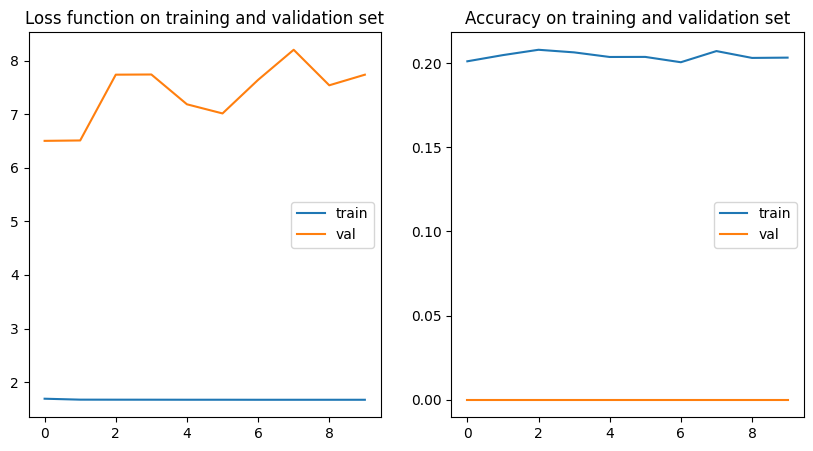

In [170]:
# After training our model, we will show the values of loss function and accuracy function
# on training and validation set throught epochs!
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Loss function on training and validation set')
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy on training and validation set')
plt.plot(history.epoch, history.history['accuracy'], label='train')
plt.plot(history.epoch, history.history['val_accuracy'], label='val')
plt.legend(loc='best')

# U slučaju da želite da sačuvate sliku grafika otkomentarišite liniju ispod
plt.savefig('the_first_results.png')

plt.show()

In [171]:
# Here we will chose model which we would like to evaluate!
model = alexnet_model

In [172]:
# Evaluiramo model na test podacima
#model.evaluate(X_test, y_test)
# Here we will evaluate the model of our interest on test data!
score=model.evaluate(test_data, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

225/225 [==============================] - 23s 102ms/step - loss: 2.9412 - accuracy: 0.2471
Test loss: 2.9411797523498535
Test accuracy: 0.24714405834674835


In [173]:
# Here we will evaluate the model of our interest on training data!
score=model.evaluate(train_data, train_labels)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

913/913 [==============================] - 94s 103ms/step - loss: 2.8823 - accuracy: 0.1642
Training loss: 2.882272720336914
Training accuracy: 0.16417910158634186


In [209]:
from sklearn.metrics import confusion_matrix, classification_report

In [210]:
# Predviđene vrednosti modela za test podatke
# Predicted values of model for the test data!

test_labels_predicted=model.predict(test_data)

225/225 [==============================] - 23s 102ms/step


In [212]:
# Vraćamo nazad na numeričke vrednosti umesto binarnih vektora

test_labels_predicted_numeric=np.argmax(test_labels_predicted, axis=1)
test_labels_numeric=np.argmax(test_labels, axis=1)


In [213]:
# Pišemo izveštaj kalsifikacije da bismo videli neke napredne statistike o klasifikovanju
print(classification_report(test_labels_numeric, test_labels_predicted_numeric))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [224]:
# Below we have a better try of creating confusion matrix and classification report!
# You should look below and ignore couple of above cells!

In [207]:
from sklearn.metrics import confusion_matrix, classification_report

In [214]:
# Trying to create a confusion matrix!
X_test=test_data
y_test=test_labels
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

225/225 [==============================] - 23s 101ms/step


In [215]:
y_predicted_classes.shape

(7178,)

In [216]:
y_test_classes = np.argmax(y_test, axis = 1) 

In [217]:
y_test_classes.shape

(7178,)

In [221]:
from sklearn.metrics import confusion_matrix, classification_report

In [222]:
confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

[[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]


In [ ]:
report = classification_report(y_test_classes, y_predicted_classes)
print(report)

In [298]:
# We will now try to test different model!

In [285]:
model = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])

In [286]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_53 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 flatten_10 (Flatten)        (None, 36864)             0         
                                                                 
 dense_30 (Dense)            (None, 128)               4718720   
                                                     

In [287]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [288]:
batch_size = 128
epochs = 12

X_train=train_data
y_train=train_labels
X_test=test_data
y_test=test_labels

In [311]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/12
183/183 [==============================] - 22s 121ms/step - loss: 0.6789 - accuracy: 0.7296 - val_loss: 11.7887 - val_accuracy: 0.1318
Epoch 2/12
183/183 [==============================] - 22s 121ms/step - loss: 0.6358 - accuracy: 0.7510 - val_loss: 14.7913 - val_accuracy: 0.1207
Epoch 3/12
183/183 [==============================] - 22s 123ms/step - loss: 0.5973 - accuracy: 0.7654 - val_loss: 14.0852 - val_accuracy: 0.1302
Epoch 4/12
183/183 [==============================] - 23s 123ms/step - loss: 0.5644 - accuracy: 0.7769 - val_loss: 13.9910 - val_accuracy: 0.1287
Epoch 5/12
183/183 [==============================] - 23s 126ms/step - loss: 0.5328 - accuracy: 0.7889 - val_loss: 15.9155 - val_accuracy: 0.1212
Epoch 6/12
183/183 [==============================] - 23s 124ms/step - loss: 0.5041 - accuracy: 0.7973 - val_loss: 16.3304 - val_accuracy: 0.1278
Epoch 7/12
183/183 [==============================] - 23s 124ms/step - loss: 0.4827 - accuracy: 0.8073 - val_loss: 16.0672 -

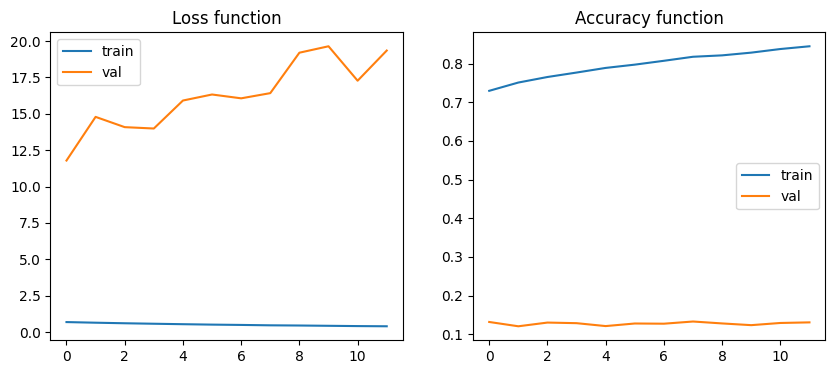

In [312]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss function')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy function')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

In [313]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.426239967346191
Test accuracy: 0.4916411340236664


In [318]:
from sklearn.metrics import confusion_matrix, classification_report

In [319]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

225/225 [==============================] - 2s 10ms/step


In [320]:
print(y_predicted[0])
print(y_test[0])
print(np.argmax(y_predicted[0]))
print(np.argmax(y_test[0]))

[1.5967314e-01 9.4473718e-05 1.0768242e-02 7.4063307e-01 8.4140308e-02
 6.1867944e-08 4.6906639e-03]
[1. 0. 0. 0. 0. 0. 0.]
3
0


In [321]:
y_predicted_classes.shape

(7178,)

In [322]:
y_test_classes = np.argmax(y_test, axis = 1) 

In [323]:
y_test_classes.shape

(7178,)

In [324]:
confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

[[ 508    2  186   77  148    0   37]
 [  42   40   16    9    2    0    2]
 [ 188    2  506   76  130    0  122]
 [ 163    0  150 1229  166    0   66]
 [ 206    3  201  126  654    0   43]
 [ 333    2  376  158  330    0   48]
 [  52    1  104   45   37    0  592]]


In [325]:
report = classification_report(y_test_classes, y_predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.53      0.41       958
           1       0.80      0.36      0.50       111
           2       0.33      0.49      0.39      1024
           3       0.71      0.69      0.70      1774
           4       0.45      0.53      0.48      1233
           5       0.00      0.00      0.00      1247
           6       0.65      0.71      0.68       831

    accuracy                           0.49      7178
   macro avg       0.47      0.47      0.45      7178
weighted avg       0.43      0.49      0.46      7178



/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [330]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd import Variable

#import transforms as transforms
from skimage import io
from skimage.transform import resize
#from models import *

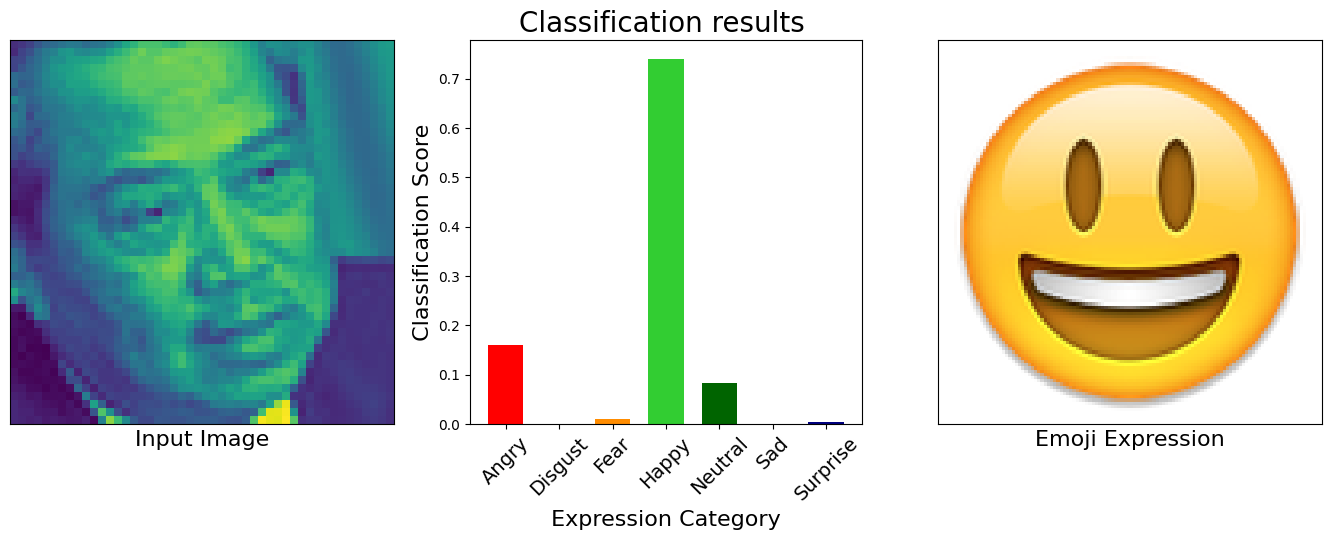

The Expression is Happy!


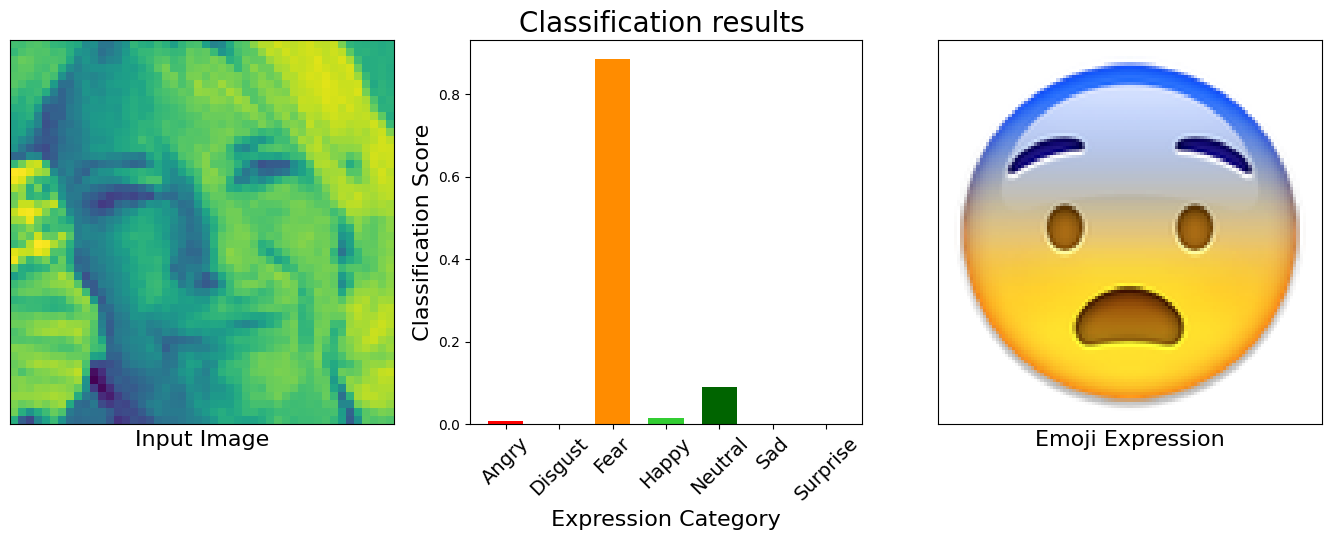

The Expression is Fear!


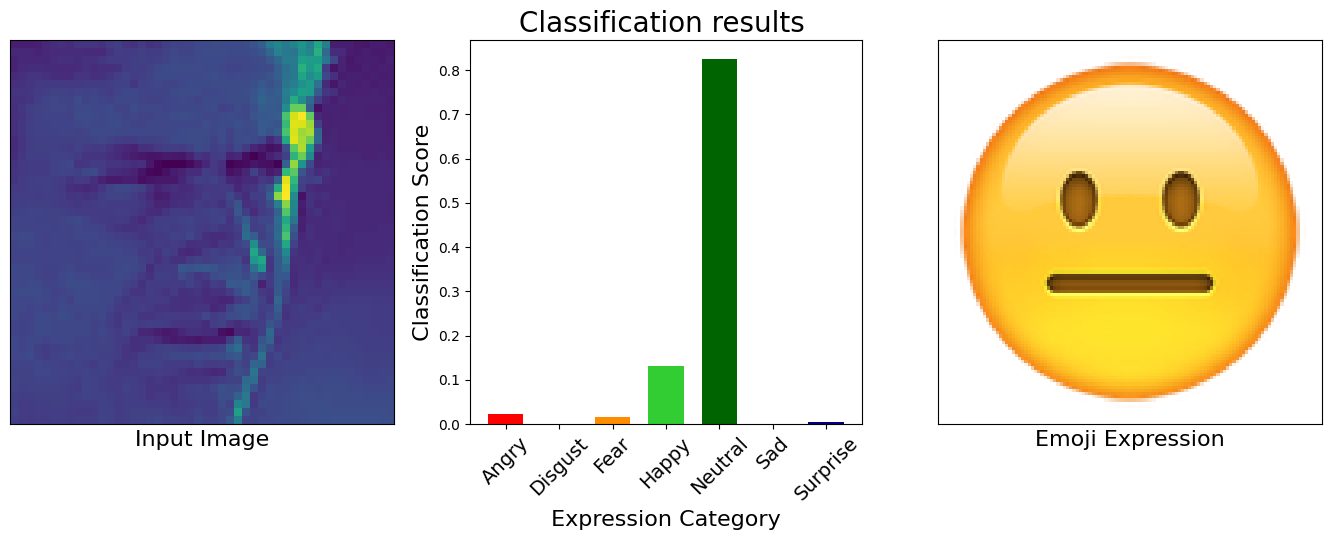

The Expression is Neutral!


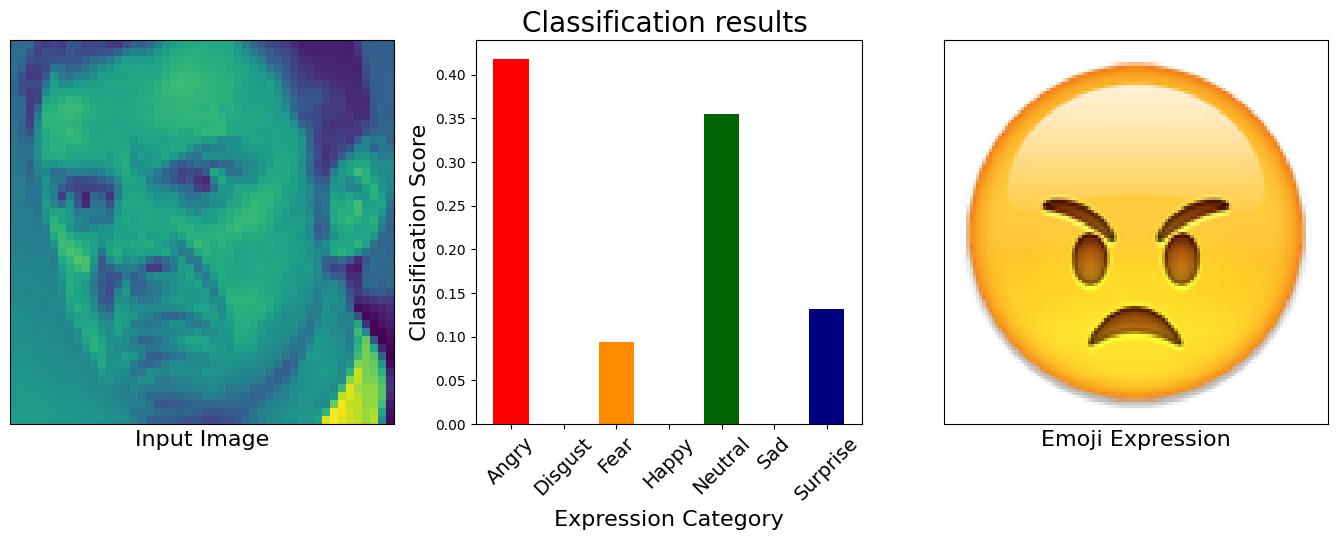

The Expression is Angry!


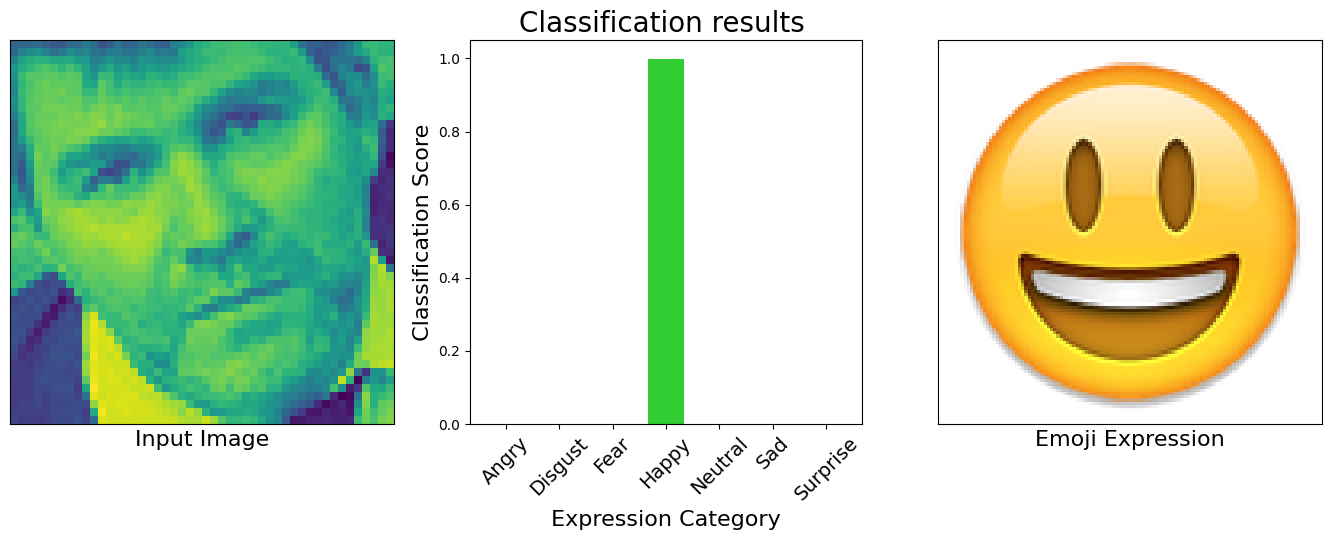

The Expression is Happy!


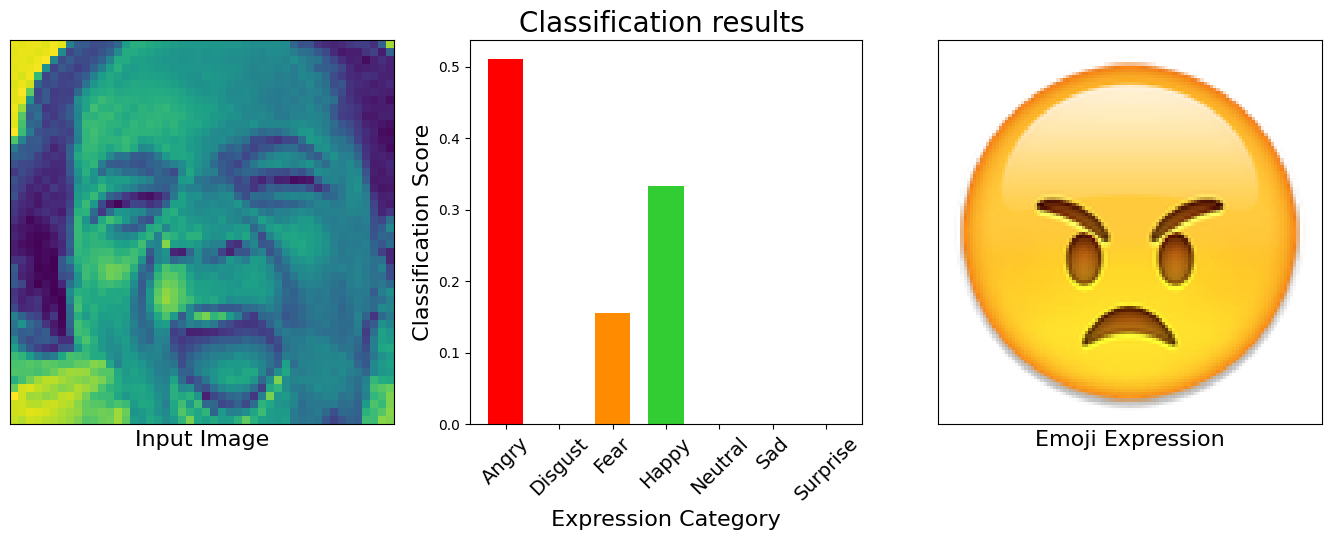

The Expression is Angry!


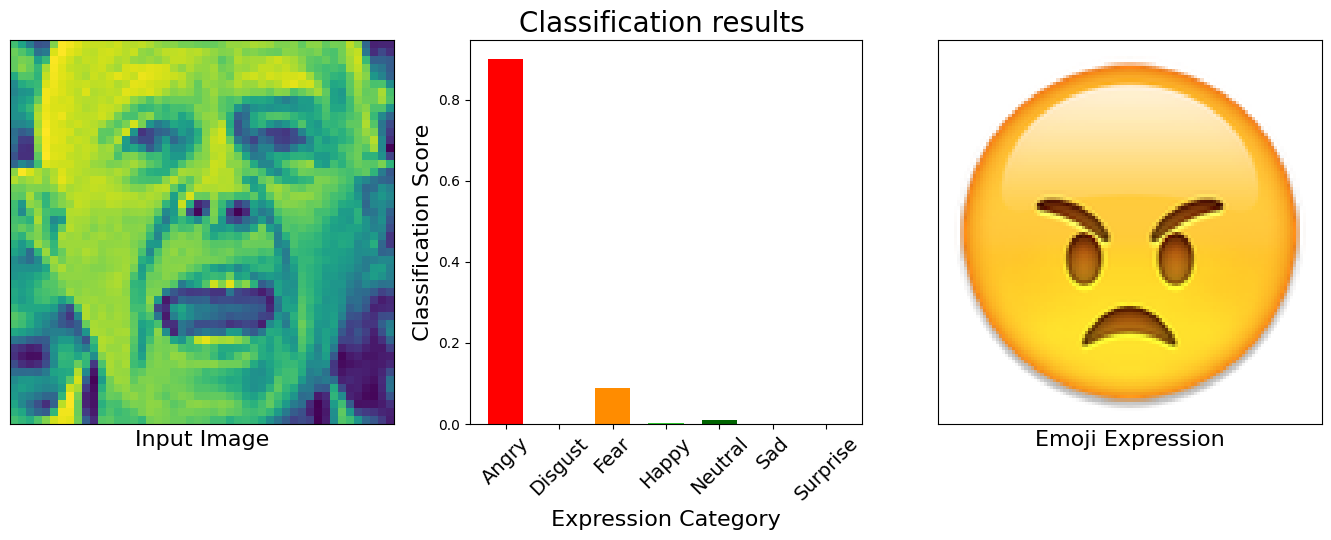

The Expression is Angry!


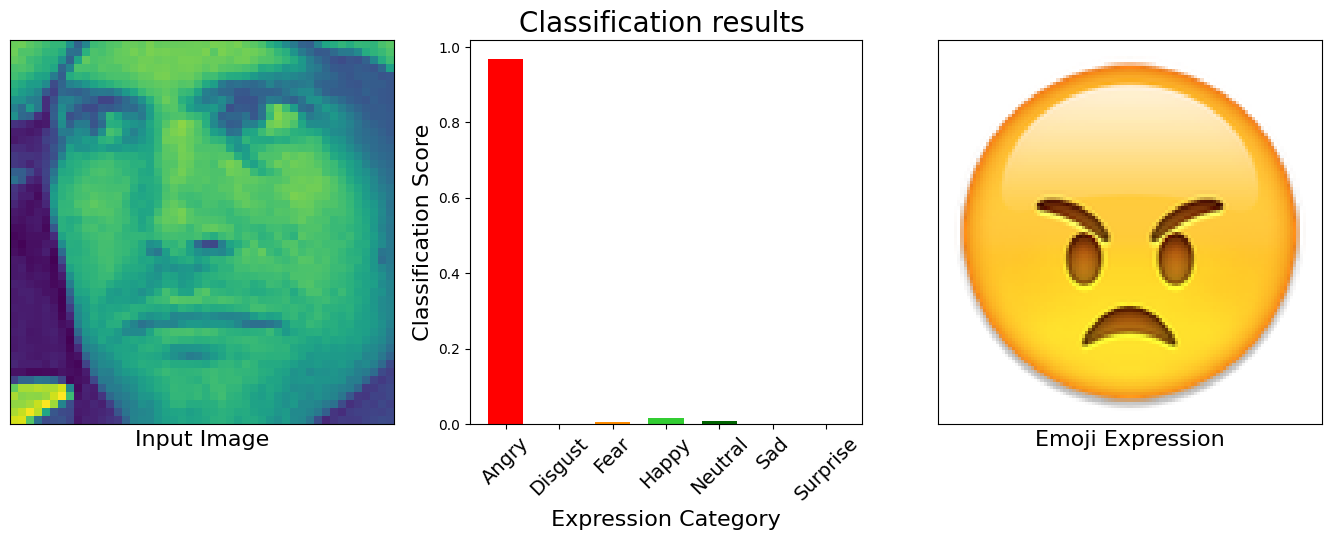

The Expression is Angry!


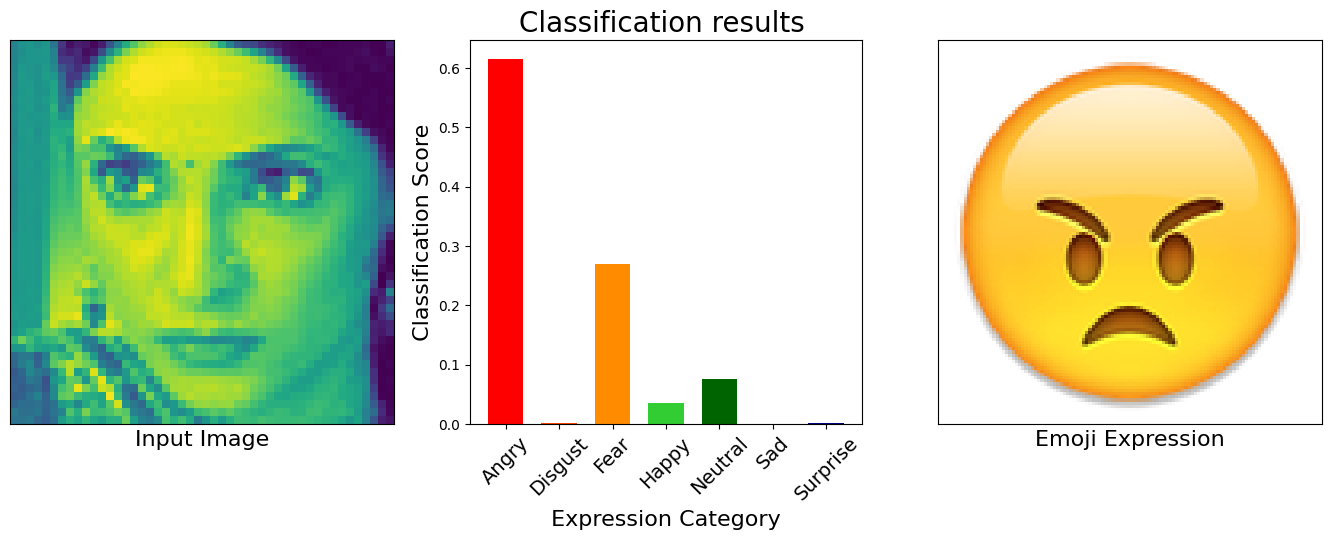

The Expression is Angry!


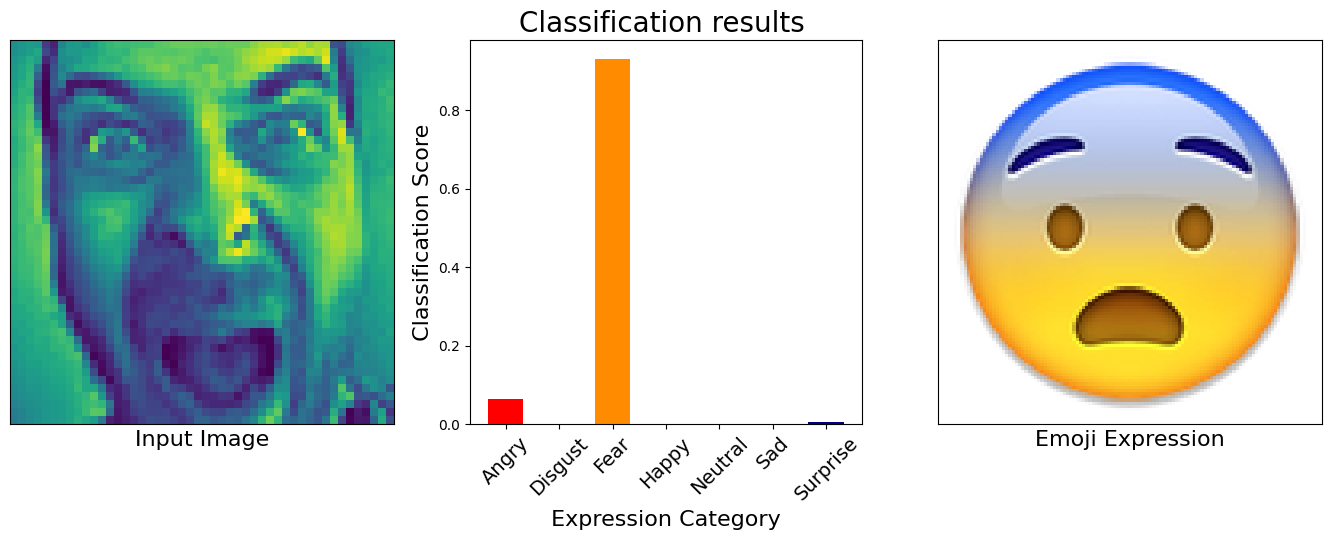

The Expression is Fear!


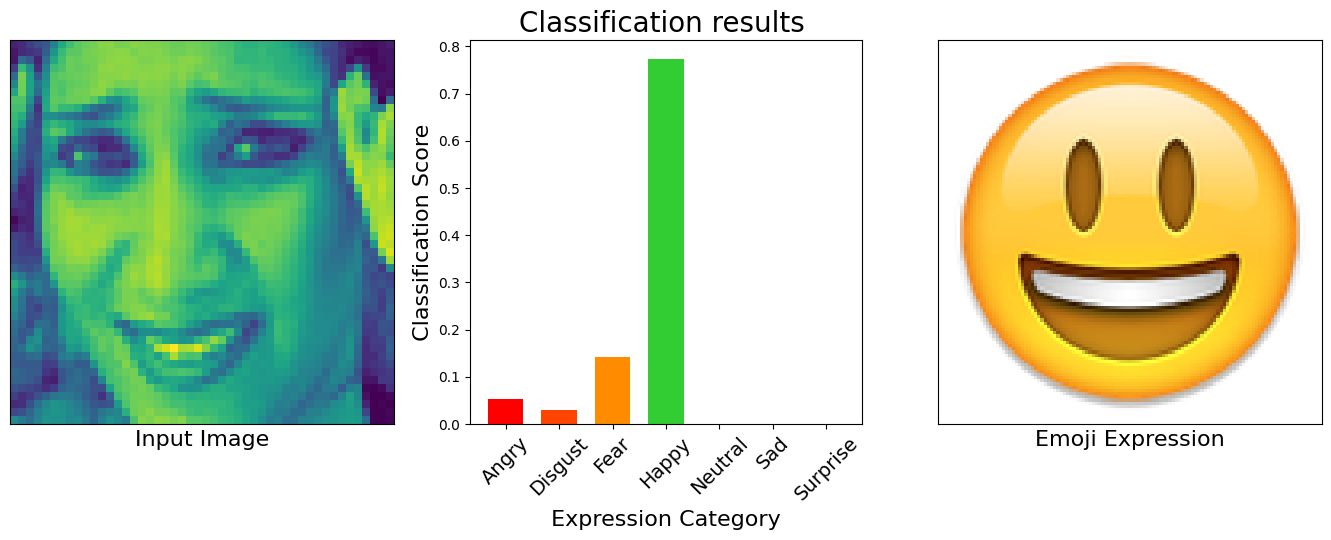

The Expression is Happy!


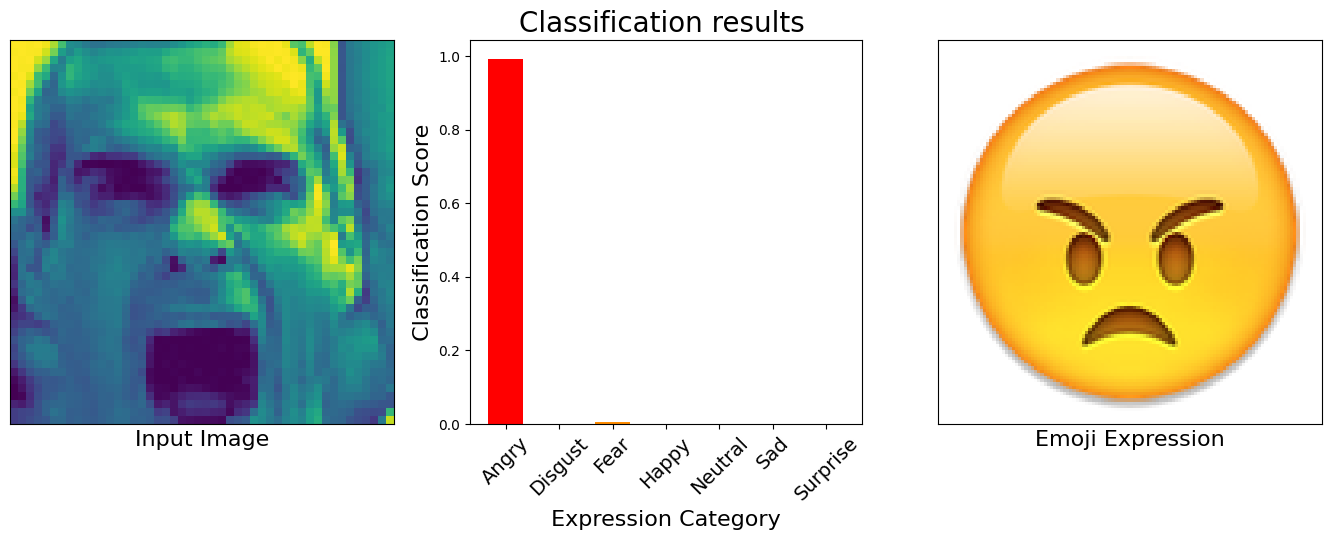

The Expression is Angry!


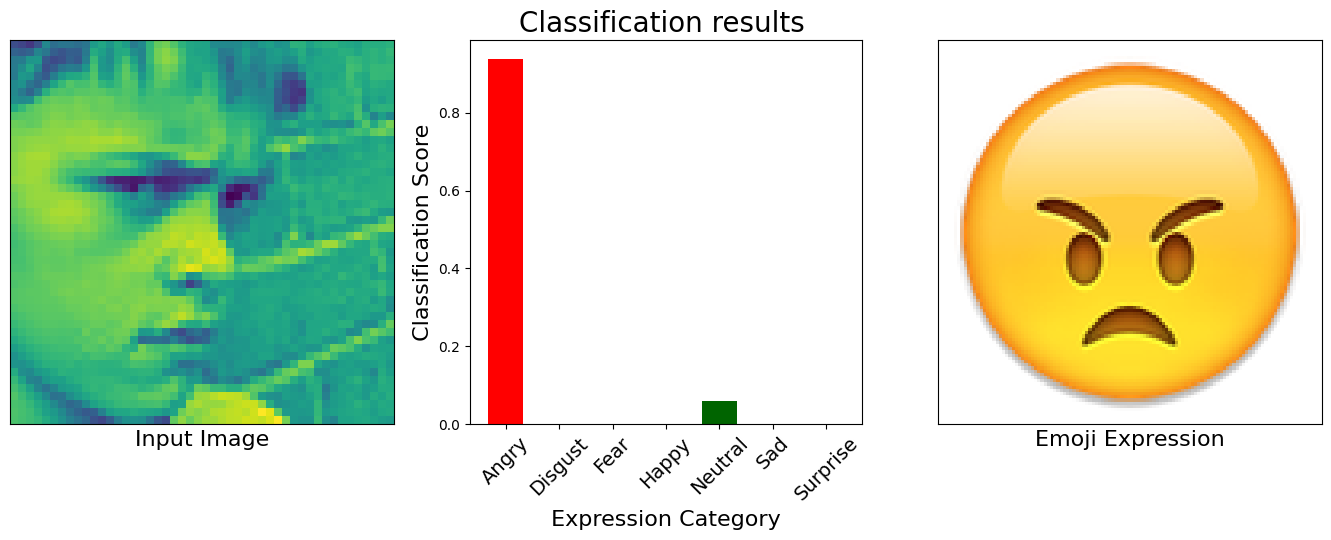

The Expression is Angry!


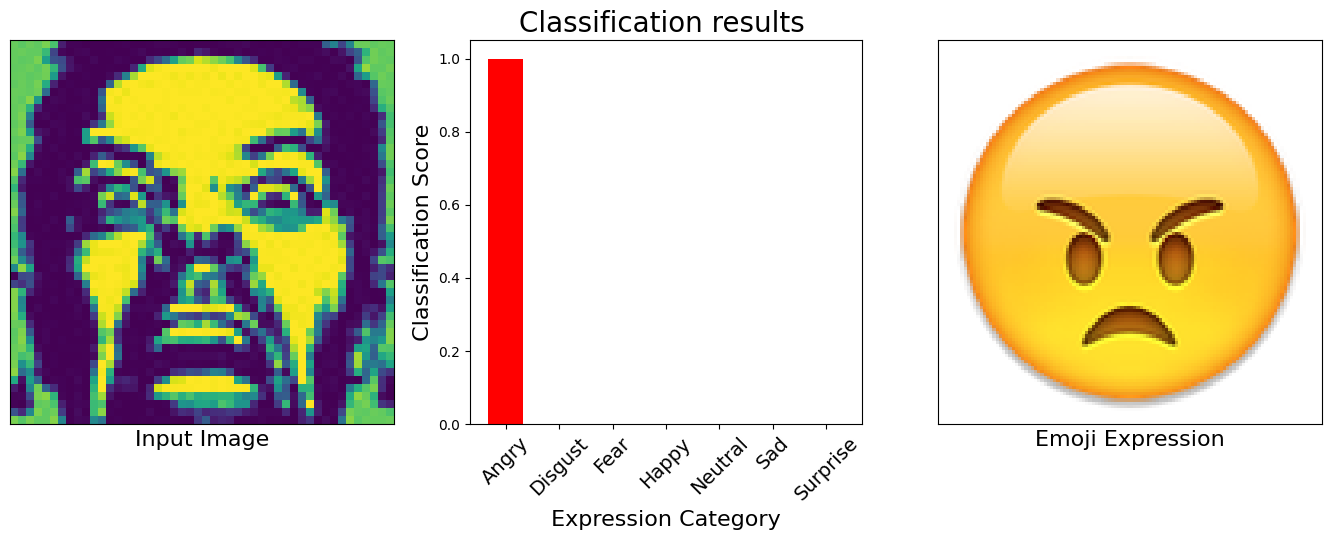

The Expression is Angry!


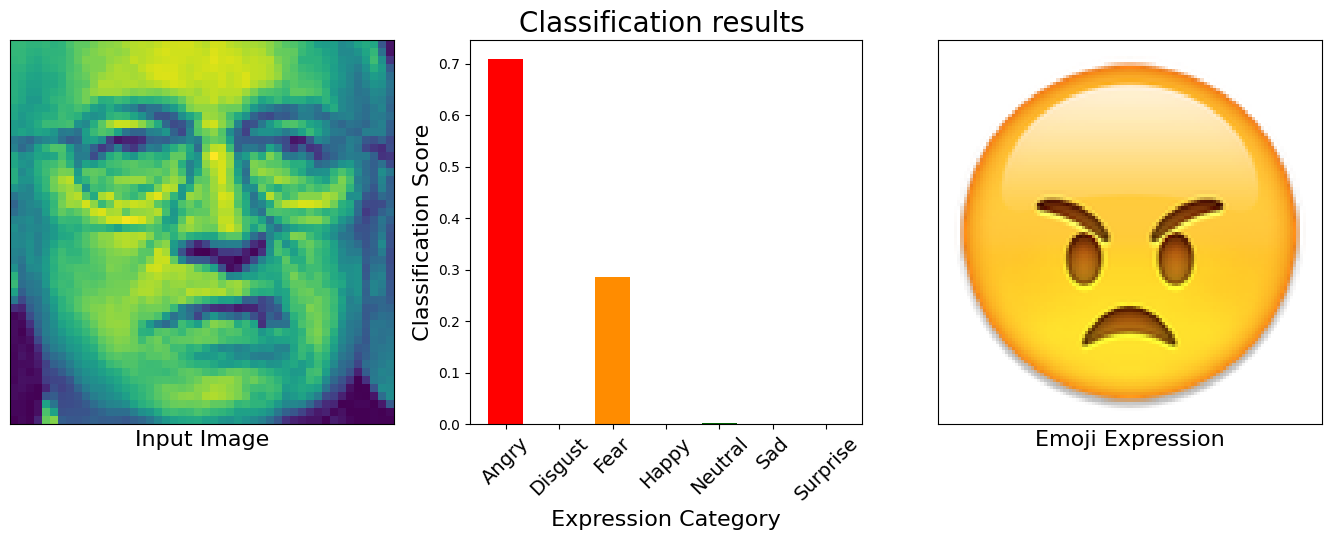

The Expression is Angry!


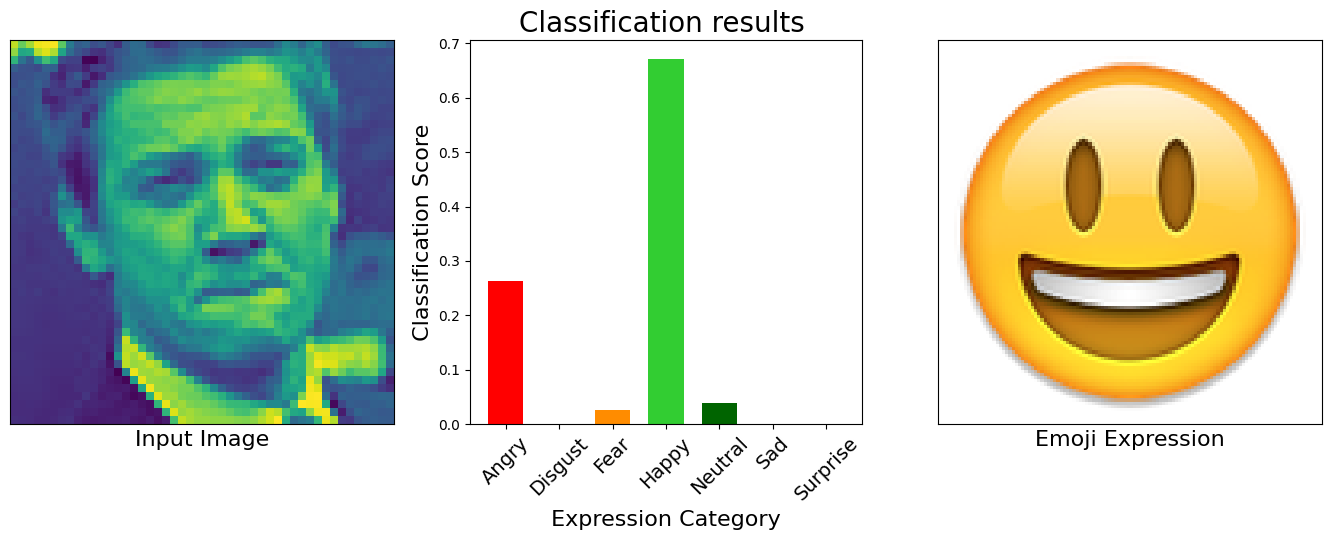

The Expression is Happy!


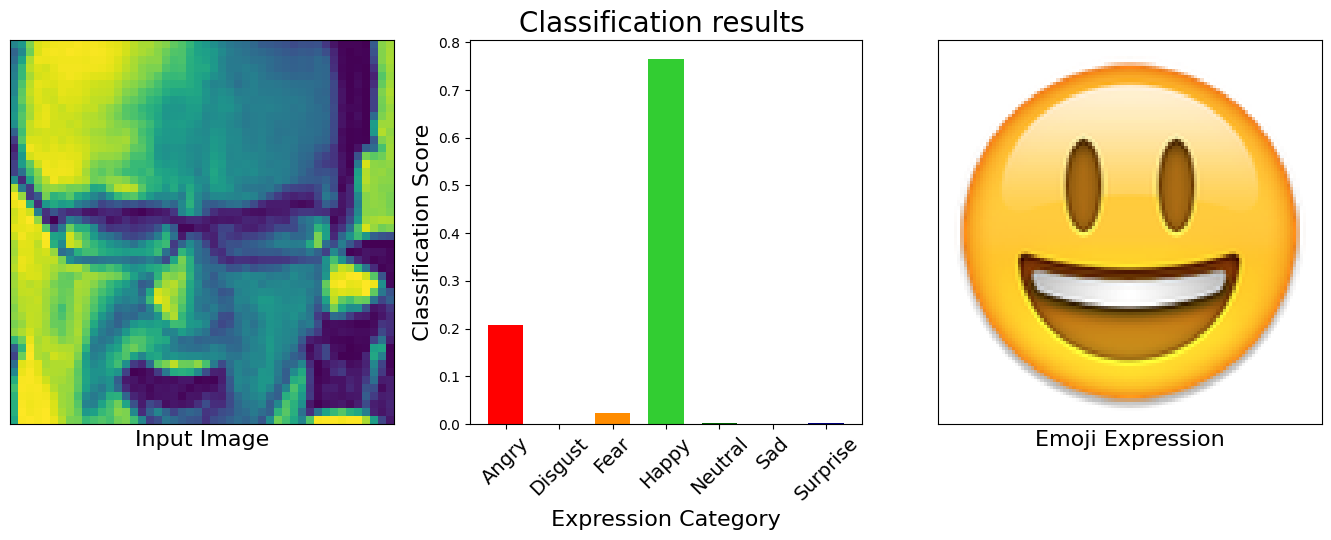

The Expression is Happy!


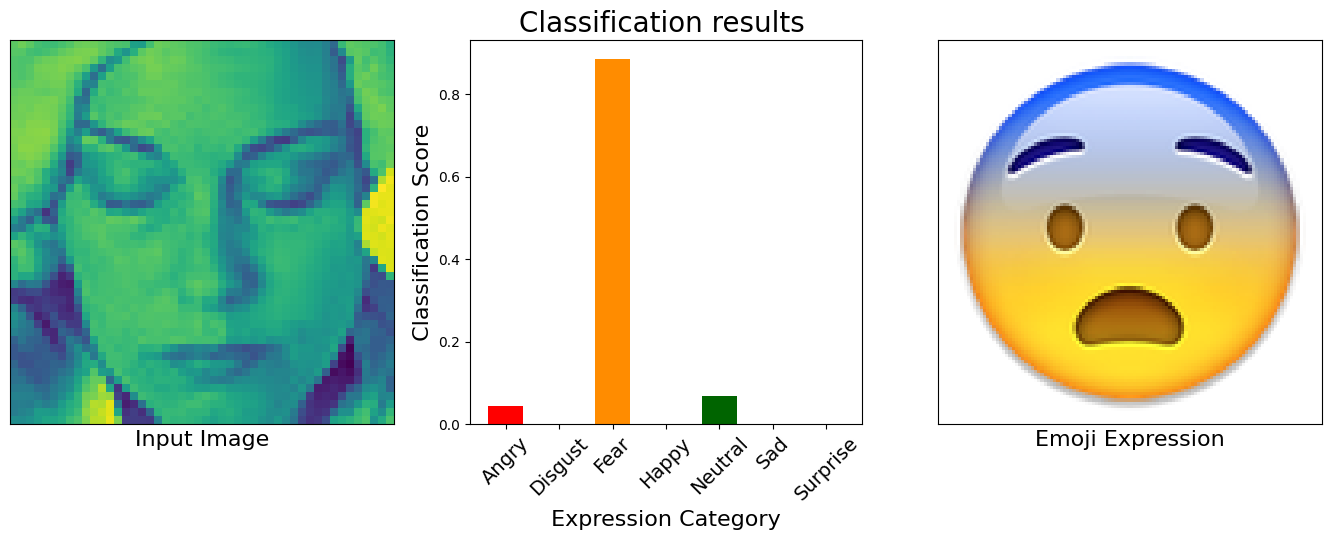

The Expression is Fear!


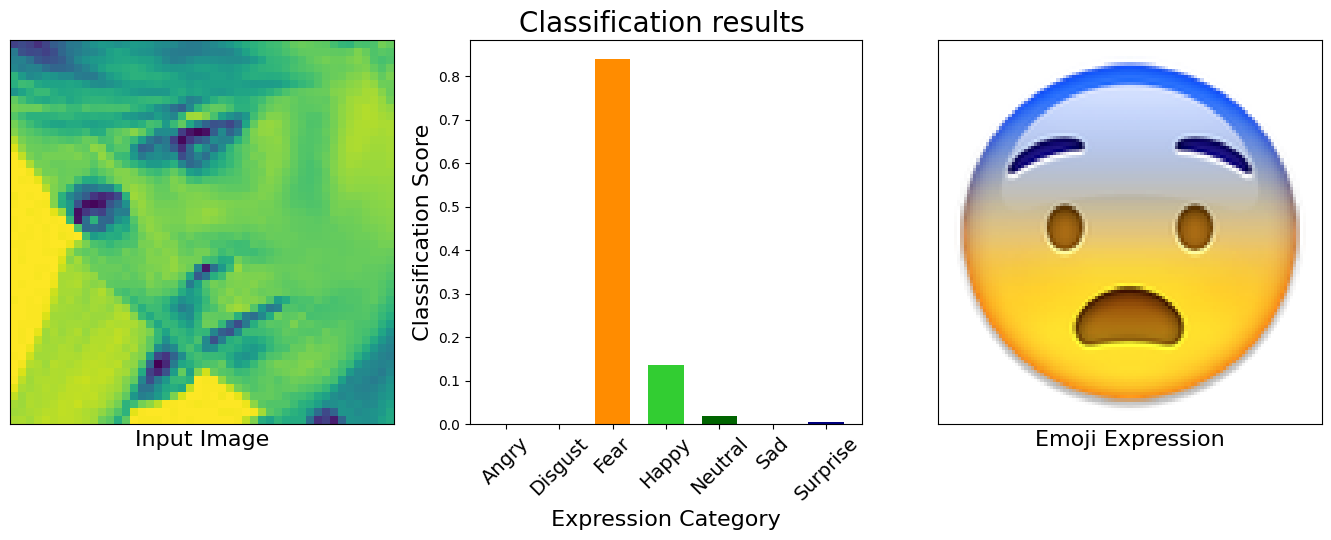

The Expression is Fear!


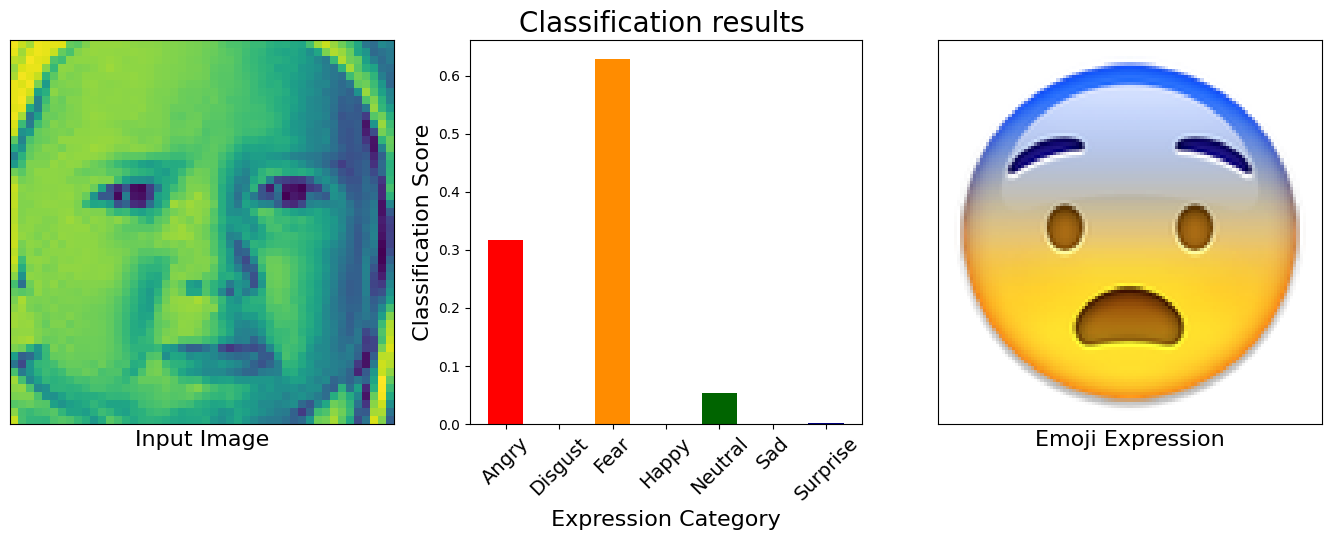

The Expression is Fear!


In [356]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' ,'Sad', 'Surprise']


for j in range(20):
    plt.rcParams['figure.figsize'] = (13.5,5.5)
    axes=plt.subplot(1, 3, 1)
    #plt.imshow(raw_img)
    plt.imshow(X_test[j])
    plt.xlabel('Input Image', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()


    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.9, hspace=0.02, wspace=0.3)

    plt.subplot(1, 3, 2)
    ind = 0.1+0.6*np.arange(len(class_names))    # the x locations for the groups
    width = 0.4       # the width of the bars: can also be len(x) sequence
    color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']
    for i in range(len(class_names)):
        plt.bar(ind[i], y_predicted[j][i], width, color=color_list[i])
    plt.title("Classification results ",fontsize=20)
    plt.xlabel(" Expression Category ",fontsize=16)
    plt.ylabel(" Classification Score ",fontsize=16)
    plt.xticks(ind, class_names, rotation=45, fontsize=14)

    axes=plt.subplot(1, 3, 3)
    emojis_img = io.imread('datasets/images/emojis/%s.png' % str(class_names[int(np.argmax(y_predicted[j]))]))
    plt.imshow(emojis_img)
    plt.xlabel('Emoji Expression', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()
    # show emojis

    plt.show()
    #plt.savefig(os.path.join('images/results/l.png'))
    plt.close()

    print("The Expression is %s!" %str(class_names[int(np.argmax(y_predicted[j]))]))